In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow_datasets.core import SplitGenerator
from tensorflow_datasets.video.bair_robot_pushing import BairRobotPushingSmall

import tempfile
import pathlib
import keras

In [ ]:
#~~~~~~~~~~~~LOAD DATA~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

TEST_DIR = pathlib.Path(tempfile.mkdtemp()) / "/home/evan/Desktop/datasets/softmotion30_44k/test"
# Since the dataset builder expects the train and test split to be downloaded,
# patch it so it only expects the test data to be available
builder = BairRobotPushingSmall()
test_generator = SplitGenerator(name='test', gen_kwargs={"filedir": str(TEST_DIR)})
builder._split_generators = lambda _: [test_generator]
builder.download_and_prepare()
data = tfds.load('bair_robot_pushing_small')
data = data['test']

n_steps =3
data = data.batch(3)

#~~~~~~~~~~~~~DONE LOAD DATA~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [5]:
#map input elemnts to input tuples from input dicts
data = data.map(lambda x: ((x['image_main'],x['image_aux1'],x['action']) , x['endeffector_pos']))


In [9]:
import keras.layers as layers
# input 2 timesteps(one duplicated because only 3 total) and output 2 to cmpare to ground truth last 2 frames
VIDEO_SHAPE = (None, 64, 64, 3)
input_main = keras.layers.Input(shape=VIDEO_SHAPE)
input_aux =      keras.layers.Input(shape=VIDEO_SHAPE)
input_act =   keras.layers.Input( shape=(None, 4), dtype=tf.float32)
main = layers.ConvLSTM2D(16, 3,return_sequences=True)(input_main)
aux = layers.ConvLSTM2D(16, 3,return_sequences=True)(input_aux)
act = layers.LSTM(10,return_sequences=True)(input_act)

main = layers.ConvLSTM2D(16, 3,return_sequences=True)(main)
aux = layers.ConvLSTM2D(16, 3,return_sequences=True)(aux)
act = layers.LSTM(10, return_sequences=True)(act)

# flat_main = keras.layers.Flatten()(main) 
# flat_aux = keras.layers.Flatten()(aux) 
# flat_act = keras.layers.Flatten()(act) 
# concat = keras.layers.Concatenate(axis=1)([flat_main, flat_aux, flat_act])
main = keras.layers.Reshape(target_shape=(-1,60 * 60 * 16))(main)
aux = keras.layers.Reshape(target_shape=(-1,60 * 60 * 16))(aux)

concat = keras.layers.Concatenate(axis=-1)([main, aux, act])
out =keras.layers.LSTM(3,activation=None,input_shape=concat.shape,return_sequences=True)(concat)


In [10]:
#~~~~~~~~~COMPILE~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import keras.backend as K
K.clear_session()
model= keras.Model(inputs=[input_main, input_aux, input_act], outputs=[out])
optimizer=keras.optimizers.Nadam()      #minimum lr=0.005   ~~~~~~~~~~~~~~~~~~~~~~   ******set lr here*****
model.compile(optimizer=optimizer, loss='mse')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 64, 64 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 64, 64 0                                            
__________________________________________________________________________________________________
conv_lst_m2d (ConvLSTM2D)       (None, None, 62, 62, 11008       input_1[0][0]                    
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, None, 62, 62, 11008       input_2[0][0]                    
_______________________________________________________________________________________

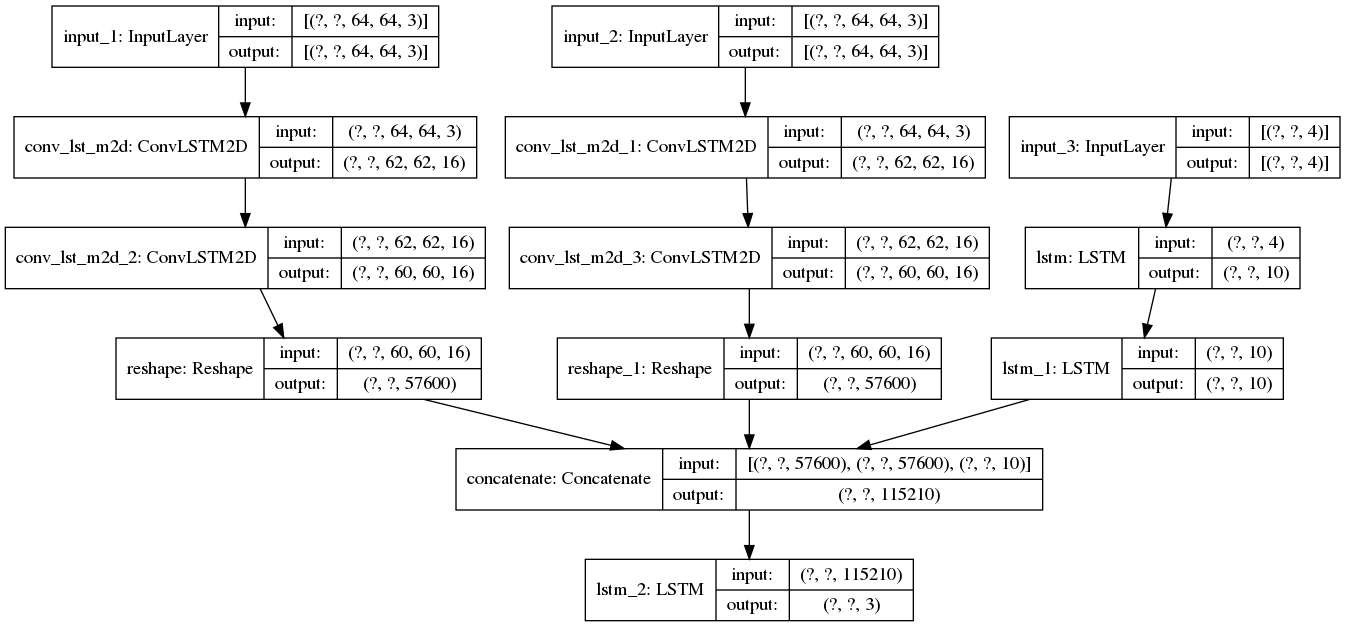

In [11]:
keras.utils.plot_model(model, "my_model.png", show_shapes=True)

In [12]:
#FOR IN 2 OUT 1:
target = data.enumerate().filter(lambda x, y: x%3==0)#target every third
target = target .map(lambda x, y : y)#remove enumeration
data=data.enumerate().filter(lambda x, y: x%3!=0)#input all except target
data = data.map(lambda x, y : y)

# data = data.window(2, shift=2, stride=1, drop_remainder=True)
# data = tf.data.Dataset.zip((data, target))



In [ ]:
target

In [ ]:
#~~~~~~~~~~~~SPLIT INTO VALID AND TRAIN

In [ ]:
# def is_test(x, _):
#     return x % 4 == 0
valid=data.enumerate().filter(lambda x, y: x%4==0)
valid= valid.map(lambda x,y:y)

train=data.enumerate().filter(lambda x, y: x%4!=0)
train= train.map(lambda x,y:y)

In [ ]:
early_stop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True) #use if training runs too long
history=model.fit(train, validation_data=valid, epochs=6, batch_size=0, callbacks=[early_stop_cb])
# model = keras.models.load_model('/home/evan/Desktop/git/projects/online_sales_model') #roll back to best model